In [20]:
import torch
import matplotlib.pyplot as plt
import torch
from torch.optim import Adam
from torch.optim import LBFGS
import time
import os

Tiempo de precomputación de Legendre polynomials: 0.5476 segundos
Tiempo de optimización: 0.7248 segundos
Tiempo de evaluación: 0.0020 segundos


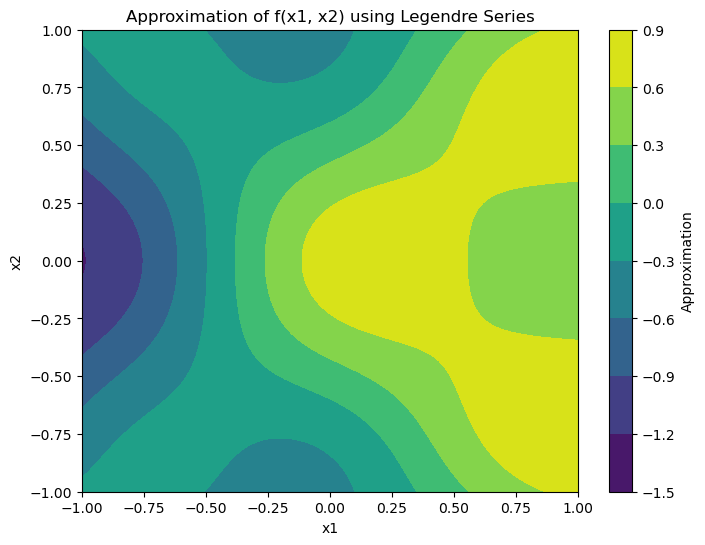

Optimal Coefficients:
tensor([ 1.1230e-01,  1.4255e-08, -1.6022e-01,  3.5330e-08, -2.4362e-02,
        -6.5447e-08,  9.5140e-03, -7.3396e-08, -9.6895e-04,  5.7293e-08,
         5.2923e-05, -3.9118e-09, -1.8379e-06, -7.7745e-09,  1.0352e-07,
        -3.6475e-08, -7.5107e-08, -9.0634e-09,  1.0572e-07, -1.5789e-08,
         7.6027e-01,  8.1615e-08, -2.8025e-01,  8.5447e-09,  8.2211e-03,
        -4.9862e-08, -8.4053e-05,  8.7650e-08,  3.8148e-07, -5.1771e-08,
         3.1134e-08, -1.0770e-07,  2.8775e-08,  3.5974e-08, -1.0264e-07,
        -2.2196e-08, -8.9866e-08, -9.6984e-09, -2.5317e-08, -3.1164e-09,
        -1.6022e-01, -1.4219e-08,  9.6935e-01, -5.4438e-09, -4.5106e-01,
         1.8102e-08,  8.1069e-02,  2.3752e-08, -7.3205e-03, -2.0123e-08,
         3.8913e-04,  8.7750e-09, -1.3869e-05,  1.2218e-08,  1.4427e-07,
        -1.7900e-08,  7.8048e-08, -1.1183e-08,  1.0244e-07, -1.2535e-08,
        -5.3051e-02, -2.7779e-09,  1.9555e-02, -1.1685e-08, -5.7351e-04,
        -2.7760e-08,  5.9239e

In [42]:
 

# Definición de la función de Legendre
def legendre(n, x):
    if n == 0:
        return torch.ones_like(x)
    elif n == 1:
        return x
    else:
        return ((2.0 * n - 1.0) * x * legendre(n - 1, x) - (n - 1) * legendre(n - 2, x)) / n

# Evaluación de la serie de Legendre 2-D utilizando broadcasting
def evaluate_legendre_series(x, y, coefficients, leg_x, leg_y):
    n = int(torch.sqrt(torch.tensor(coefficients.numel()).float()))  # Convert to tensor before sqrt
    coefficients = coefficients.view(n, n)
    
    # Utilizando broadcasting para calcular la serie de Legendre
    result = torch.sum(coefficients[:, :, None, None] * leg_x[:, None, :, :] * leg_y[None, :, :, :], dim=(0, 1))
    
    return result

# Define la función para la cual quieres calcular los coeficientes de la serie de Legendre
def f(x1, x2):
    return torch.sin(x1) * torch.cos(x2) + 0.5 * torch.cos(2*x1) * torch.cos(2*x2) + 0.25 * torch.cos(4*x1) * torch.cos(4*x2)

# Define la función de error
def error_function(coefficients, leg_x, leg_y):
    approximation = evaluate_legendre_series(X1, X2, coefficients, leg_x, leg_y)
    error = torch.sum((f(X1, X2) - approximation) ** 2)
    return error

# Elige una suposición inicial para los coeficientes
N = 20  # Grado máximo de los polinomios de Legendre
initial_guess = torch.zeros(N * N, requires_grad=True)  # Suposición inicial para los coeficientes

# Datos de entrada para la función y los polinomios de Legendre
X1, X2 = torch.meshgrid(torch.linspace(-1, 1, 100), torch.linspace(-1, 1, 100))
 
# Importar el optimizador LBFGS
from torch.optim import LBFGS

# Usar una función de optimización para minimizar la función de error con respecto a los coeficientes
optimizer = LBFGS([initial_guess], lr=1)

# Precomputar leg_x y leg_y una vez
start_precompute = time.time()
n = int(torch.sqrt(torch.tensor(initial_guess.numel()).float()))
leg_x = torch.stack([legendre(i, X1) for i in range(n)], dim=0)
leg_y = torch.stack([legendre(j, X2) for j in range(n)], dim=0)
end_precompute = time.time()

# Medir el tiempo de precomputación
time_precompute = end_precompute - start_precompute
print(f"Tiempo de precomputación de Legendre polynomials: {time_precompute:.4f} segundos")

def closure():
    optimizer.zero_grad()
    loss = error_function(initial_guess, leg_x, leg_y)
    loss.backward()
    return loss

# Realizar pasos de optimización
start_optimization = time.time()
for _ in range(100):  # Número de pasos de optimización
    optimizer.step(closure)
end_optimization = time.time()

# Coeficientes óptimos encontrados
optimal_coefficients = initial_guess.detach()

# Evaluar la aproximación de la serie de Legendre
start_evaluation = time.time()
approximation = evaluate_legendre_series(X1, X2, optimal_coefficients, leg_x, leg_y)
end_evaluation = time.time()

# Medir el tiempo de optimización y evaluación
time_optimization = end_optimization - start_optimization
time_evaluation = end_evaluation - start_evaluation

print(f"Tiempo de optimización: {time_optimization:.4f} segundos")
print(f"Tiempo de evaluación: {time_evaluation:.4f} segundos")

# Graficar el resultado usando contourf
plt.figure(figsize=(8, 6))
plt.contourf(X1, X2, approximation.cpu().numpy(), cmap='viridis')
plt.colorbar(label='Approximation')
plt.title('Approximation of f(x1, x2) using Legendre Series')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

print("Optimal Coefficients:")
print(optimal_coefficients)
